In [15]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

train_embs = pickle_load(r"D:/train_embs.pkl")
test_embs = pickle_load(r"D:/test_embs.pkl")
train_df = pd.read_csv('train.csv')

In [8]:
from collections import defaultdict
from tqdm import tqdm

def dict2list(embs):
    keys = list(embs.keys())
    values = [embs[k] for k in keys]
    return keys, np.stack(values)

def compute_sim(train_embs, test_embs):
    # Compute center of each individual id
    label2emb = defaultdict(list)
    for label, d in train_df.groupby('individual_id'):
        for img_id in d.image.values:
            if img_id in train_embs:
                label2emb[label].append(train_embs[img_id])
    for k, v in label2emb.items():
        avg = np.mean(np.stack(v),0)
        label2emb[k] = avg / np.linalg.norm(avg)

    train_k, train_v = dict2list(label2emb)
    test_k, test_v = dict2list(test_embs)

    cos = np.matmul(test_v, train_v.T)

    records = []

    for i, scores in enumerate(tqdm(cos)):
        sort_idx = np.argsort(scores)[::-1]
        records.append([test_k[i], " ".join([train_k[j] for j in sort_idx[:5]])])
        best = scores[sort_idx[0]]
        # if best >= 0.5:
        #     print(best)

    sim_df = pd.DataFrame(records, columns=['image', 'predictions'])
    sim_df[["image", "predictions"]].to_csv("submission.csv", index=False)
    return sim_df

sim_df = compute_sim(train_embs, test_embs)

100%|██████████| 27956/27956 [00:20<00:00, 1377.82it/s]


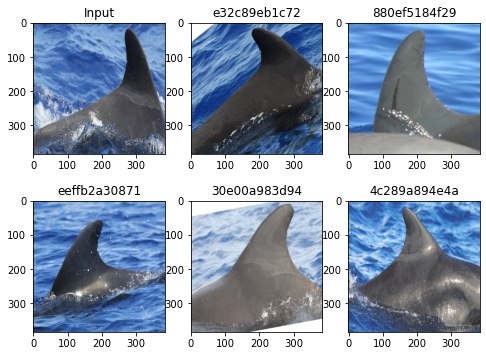

In [55]:
def random_show(sim_df):
    sample = sim_df.iloc[np.random.choice(sim_df.index)]
    img1 = cv2.imread(f'D:/whale_data/test_images-384-384/test_images-384-384/{sample.image}')[:, :, ::-1]
    imgs = [img1]

    ids = sample.predictions.split(" ")
    for i in range(5):
        path = train_df[train_df.individual_id == ids[i]].values[0][0]
        img = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{path}')[:, :, ::-1]
        imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i == 0:
            plt.title('Input')
        else:
            plt.title(ids[i-1])
        plt.imshow(imgs[i])
    plt.show()

random_show(sim_df)